In [2]:
from importer_snippets import load_experiment
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('JGW')

# Impedance fitting package: https://impedancepy.readthedocs.io/en/latest/index.html
from impedance.models.circuits import CustomCircuit
from impedance.preprocessing import ignoreBelowX
from impedance.visualization import plot_nyquist, plot_residuals
from impedance.validation import linKK, eval_linKK

In [3]:
EIS = load_experiment() # Warning - this function may take ~5 minutes to run if loading .xlsx.

In [4]:
Zseries = EIS.data['Zre'] + 1j*EIS.data['Zim']
f, Z = EIS.data['f'].to_numpy(), Zseries.to_numpy()
n = 0
for i in Z:
    if np.real(i) < 0 or -np.imag(i) < 0:
        n += 1
print(str(n)+' improperly signed impedances have been excluded')
f, Z = ignoreBelowX(f, Z)

0 improperly signed impedances have been excluded


In [5]:
circuit = 'R1-p(R2-W1,C1)' # Randles Circuit
# initial_guess = [500, 250, 100, 5e-6]
initial_guess = [500, 500, 1000, 4e-6]

# circuit = 'R1-p(R2,C2)-p(R3,C3)' # Tsierkezos-Ritter Circuit
# initial_guess = [500, 250, 100e-6, 250, 100e-6] 

circuit = CustomCircuit(circuit, initial_guess=initial_guess)
circuit.fit(f, Z) # Comment out this line to skip regression of circuit elements
fit = circuit.predict(np.linspace(f[0], f[-1], 10000))

# Check the fit
print(circuit)
# circuit.plot(ax=ax) # Get some other fit plots


Circuit string: R1-p(R2-W1,C1)
Fit: True

Initial guesses:
     R1 = 5.00e+02 [Ohm]
     R2 = 5.00e+02 [Ohm]
     W1 = 1.00e+03 [Ohm sec^-1/2]
     C1 = 4.00e-06 [F]

Fit parameters:
     R1 = 9.55e+01  (+/- 4.74e+01) [Ohm]
     R2 = 3.90e-01  (+/- 2.31e+06) [Ohm]
     W1 = 1.16e+04  (+/- 1.12e+03) [Ohm sec^-1/2]
     C1 = 1.14e-05  (+/- 8.59e-03) [F]



In [8]:
def save_Nyq_fig(fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig("C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\Nyq_"+
            analyte + electrode + solvent + notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

10 0.9971596449776063 4.244113462844024

Completed Lin-KK Fit
M = 19
mu = 0.48


<AxesSubplot:xlabel='$f$ [Hz]', ylabel='$\\Delta$ $(\\%)$'>

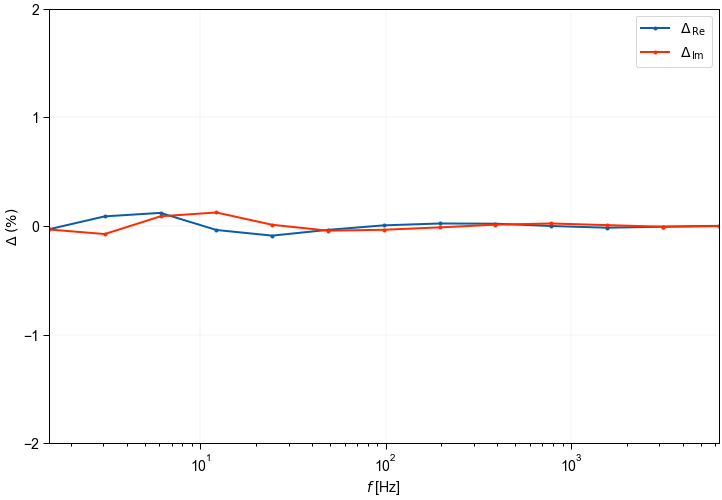

In [11]:
# Schönleber, M.; Klotz, D.; Ivers-Tiffée, E. A Method for Improving the Robustness of Linear Kramers-Kronig Validity Tests. Electrochim. Acta 2014, 131, 20–27. doi.org/10.1016/j.electacta.2014.01.034.
M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))
fig, ax = plt.subplots()
plot_residuals(ax, f, res_real, res_imag, y_limits=(-2,2))

# print(np.real(Z_linKK), np.imag(Z_linKK))

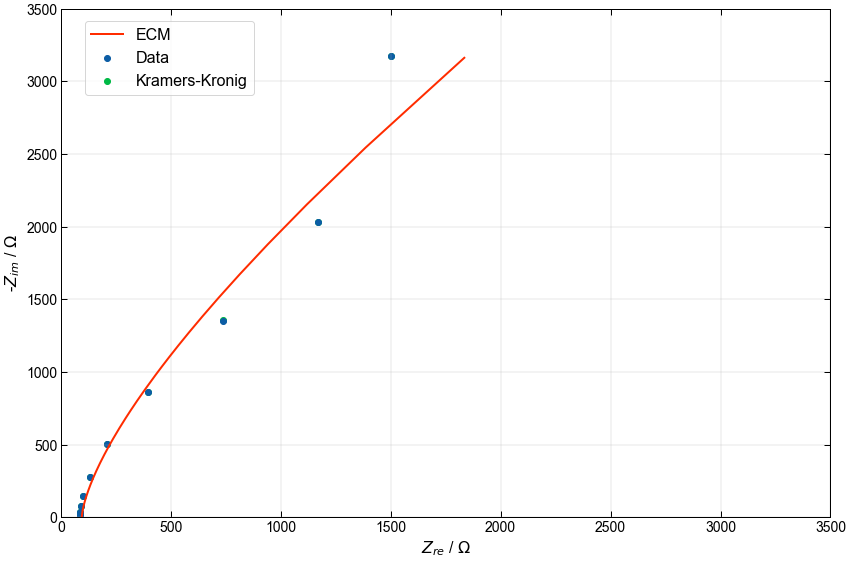

Save the figure? n


Not saved


In [13]:
# Nyquist
fig = plt.figure()
ax = fig.add_subplot()

# ax.set_title('Nyquist Plot')

ax.scatter(EIS.data['Zre'], -EIS.data['Zim'], label = 'Data') # Plot experimental data
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_xlabel('$Z_{re}$ / $\Omega$')
ax.set_ylabel('-$Z_{im}$ / $\Omega$')
ax.set_xlim ([0,1.1*max(EIS.data['Zre'])])
ax.set_ylim ([0,1.1*max(-EIS.data['Zim'])])
ax.plot(np.real(fit), -np.imag(fit), label='ECM', color='C1') # Plot circuit fit
ax.scatter(np.real(Z_linKK), -np.imag(Z_linKK), label='Kramers-Kronig', color='C2', zorder=0) # Plot LinKK result
ax.set_xlim(0, 3500)
ax.set_ylim(0, 3500)

fig.tight_layout()
fig.legend(loc=(.1, .83))

analyte = 'TBAF_'
electrode = 'Au_'
solvent = 'MeCN_'
notebook = '_P-04-03'

plt.show()
save_Nyq_fig(fig, analyte, electrode, solvent, notebook)